In [ ]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, mean_absolute_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from scipy.stats import uniform


# DATA CLEANING & EDA

In [ ]:
#!unzip Combined_Flights_2021.csv.zip

In [ ]:
# load raw data
# This may take a while (2-3 min)
df_raw = pd.read_csv('Combined_Flights_2021.csv')
df_raw.head()

,FlightDate,Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,DepTime,DepDelayMinutes,DepDelay,...,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrDelay,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,DistanceGroup,DivAirportLandings
0,2021-03-03,SkyWest Airlines Inc.,SGU,PHX,False,False,724,714.0,0.0,-10.0,...,724.0,813.0,5.0,843,-25.0,0.0,-2.0,0800-0859,2,0.0
1,2021-03-03,SkyWest Airlines Inc.,PHX,SGU,False,False,922,917.0,0.0,-5.0,...,940.0,1028.0,3.0,1040,-9.0,0.0,-1.0,1000-1059,2,0.0
2,2021-03-03,SkyWest Airlines Inc.,MHT,ORD,False,False,1330,1321.0,0.0,-9.0,...,1336.0,1445.0,16.0,1530,-29.0,0.0,-2.0,1500-1559,4,0.0
3,2021-03-03,SkyWest Airlines Inc.,DFW,TRI,False,False,1645,1636.0,0.0,-9.0,...,1703.0,1955.0,7.0,2010,-8.0,0.0,-1.0,2000-2059,4,0.0
4,2021-03-03,SkyWest Airlines Inc.,PHX,BFL,False,False,1844,1838.0,0.0,-6.0,...,1851.0,1900.0,3.0,1925,-22.0,0.0,-2.0,1900-1959,2,0.0


In [ ]:
# get shape of raw data: 6311871 instances, 61 columns
df_raw.shape

(6311871, 61)

In [ ]:
# checking if data is concentrated around specific time of year, month, week
# - No, we are good.

# # we can drop year since all records are from 2021
# df_raw.Year.value_counts()

# # we can keep Quarter
# df_raw.Quarter.value_counts()

# # we can keep Month
# df_raw.Month.value_counts().sort_index()

# # we can keep DayofMonth, if needed
# df_raw.DayofMonth.value_counts().sort_index()

# # we can keep DayOfWeek
df_raw.DayOfWeek.value_counts().sort_index()

DayOfWeek
1    939051
2    839768
3    859163
4    943687
5    953855
6    840721
7    935626
Name: count, dtype: int64

In [ ]:
df_raw.columns

Index(['FlightDate', 'Airline', 'Origin', 'Dest', 'Cancelled', 'Diverted',
       'CRSDepTime', 'DepTime', 'DepDelayMinutes', 'DepDelay', 'ArrTime',
       'ArrDelayMinutes', 'AirTime', 'CRSElapsedTime', 'ActualElapsedTime',
       'Distance', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek',
       'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners',
       'DOT_ID_Marketing_Airline', 'IATA_Code_Marketing_Airline',
       'Flight_Number_Marketing_Airline', 'Operating_Airline',
       'DOT_ID_Operating_Airline', 'IATA_Code_Operating_Airline',
       'Tail_Number', 'Flight_Number_Operating_Airline', 'OriginAirportID',
       'OriginAirportSeqID', 'OriginCityMarketID', 'OriginCityName',
       'OriginState', 'OriginStateFips', 'OriginStateName', 'OriginWac',
       'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'DestCityName',
       'DestState', 'DestStateFips', 'DestStateName', 'DestWac', 'DepDel15',
       'DepartureDelayGroups', 'DepTimeBlk', 'TaxiOu

In [ ]:
# select relevant columns
relevant_columns = ['Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'CRSDepTime', 'CRSArrTime'  # Group 1 - Flight Time
          , 'DepTime', 'ArrTime', 'ActualElapsedTime', 'CRSElapsedTime' # Group 1 - Flight Time
          ,'DOT_ID_Operating_Airline', 'Operating_Airline', 'Airline' # Group 2 - Airline
          ,'Flight_Number_Operating_Airline', 'Tail_Number' # Group 3 - Flight Number & Aircraft Number
          , 'OriginAirportID', 'Origin', 'OriginCityName', 'OriginStateName' # Group 4 - Origin Airport/Location
          , 'DestAirportID', 'Dest', 'DestCityName', 'DestStateName' # Group 5 - Destination Airport/Location
          , 'Distance', 'DistanceGroup' # Group 6 - Distance
         # , 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay' # Additional Info - Delay Reasons !cannot find in 2021 data!
          , 'FlightDate' # for convenience
          , 'DepDelayMinutes', 'DepDel15', 'DepartureDelayGroups' # Target Variables: Departure delays (for Continuous, Binary, and Categorical)
          , 'ArrDelayMinutes', 'ArrDel15', 'ArrivalDelayGroups'] # Target Variables: Arrival delays (for Continuous, Binary, and Categorical)

df_relevant = df_raw[relevant_columns]
df_relevant.shape

(6311871, 32)

In [ ]:
# check null values
df_relevant.isnull().sum().sort_values(ascending = False)

ArrivalDelayGroups                 126001
ArrDel15                           126001
ArrDelayMinutes                    126001
ActualElapsedTime                  126001
ArrTime                            112408
DepDelayMinutes                    108413
DepartureDelayGroups               108413
DepDel15                           108413
DepTime                            108325
Tail_Number                         23303
CRSElapsedTime                          1
FlightDate                              0
DistanceGroup                           0
Distance                                0
DestAirportID                           0
DestStateName                           0
DestCityName                            0
Dest                                    0
Quarter                                 0
OriginStateName                         0
OriginCityName                          0
Month                                   0
OriginAirportID                         0
Flight_Number_Operating_Airline   

In [ ]:
# drop rows with NA values, and save as new df
df_relevant_nonull = df_relevant.dropna()

# check null values again
df_relevant_nonull.isnull().sum().sort_values(ascending = False)

Quarter                            0
Month                              0
ArrDel15                           0
ArrDelayMinutes                    0
DepartureDelayGroups               0
DepDel15                           0
DepDelayMinutes                    0
FlightDate                         0
DistanceGroup                      0
Distance                           0
DestStateName                      0
DestCityName                       0
Dest                               0
DestAirportID                      0
OriginStateName                    0
OriginCityName                     0
Origin                             0
OriginAirportID                    0
Tail_Number                        0
Flight_Number_Operating_Airline    0
Airline                            0
Operating_Airline                  0
DOT_ID_Operating_Airline           0
CRSElapsedTime                     0
ActualElapsedTime                  0
ArrTime                            0
DepTime                            0
C

In [ ]:
df_relevant_nonull.tail(5)

,Quarter,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,DepTime,ArrTime,ActualElapsedTime,CRSElapsedTime,...,DestStateName,Distance,DistanceGroup,FlightDate,DepDelayMinutes,DepDel15,DepartureDelayGroups,ArrDelayMinutes,ArrDel15,ArrivalDelayGroups
6311866,2,6,1,2,1255,1430,1301.0,1421.0,80.0,95.0,...,Illinois,395.0,2,2021-06-01,6.0,0.0,0.0,0.0,0.0,-1.0
6311867,2,6,1,2,730,900,727.0,845.0,78.0,90.0,...,Illinois,395.0,2,2021-06-01,0.0,0.0,-1.0,0.0,0.0,-1.0
6311868,2,6,1,2,800,1110,757.0,1101.0,124.0,130.0,...,Florida,806.0,4,2021-06-01,0.0,0.0,-1.0,0.0,0.0,-1.0
6311869,2,6,1,2,1300,1620,1252.0,1559.0,127.0,140.0,...,Florida,806.0,4,2021-06-01,0.0,0.0,-1.0,0.0,0.0,-2.0
6311870,2,6,1,2,1925,2055,1948.0,2116.0,88.0,90.0,...,Wisconsin,475.0,2,2021-06-01,23.0,1.0,1.0,21.0,1.0,1.0


In [ ]:
# check shape
df_relevant_nonull.shape

(6185870, 32)

In [ ]:
# check data types
df_relevant_nonull.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6185870 entries, 0 to 6311870
Data columns (total 32 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   Quarter                          int64  
 1   Month                            int64  
 2   DayofMonth                       int64  
 3   DayOfWeek                        int64  
 4   CRSDepTime                       int64  
 5   CRSArrTime                       int64  
 6   DepTime                          float64
 7   ArrTime                          float64
 8   ActualElapsedTime                float64
 9   CRSElapsedTime                   float64
 10  DOT_ID_Operating_Airline         int64  
 11  Operating_Airline                object 
 12  Airline                          object 
 13  Flight_Number_Operating_Airline  int64  
 14  Tail_Number                      object 
 15  OriginAirportID                  int64  
 16  Origin                           object 
 17  OriginCityNam

In [ ]:
df_relevant_nonull.describe()

,Quarter,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,DepTime,ArrTime,ActualElapsedTime,CRSElapsedTime,...,OriginAirportID,DestAirportID,Distance,DistanceGroup,DepDelayMinutes,DepDel15,DepartureDelayGroups,ArrDelayMinutes,ArrDel15,ArrivalDelayGroups
count,6.185870e+06,6.185870e+06,6.185870e+06,6.185870e+06,6.185870e+06,6.185870e+06,6.185870e+06,6.185870e+06,6.185870e+06,6.185870e+06,...,6.185870e+06,6.185870e+06,6.185870e+06,6.185870e+06,6.185870e+06,6.185870e+06,6.185870e+06,6.185870e+06,6.185870e+06,6.185870e+06
mean,2.650939e+00,6.971771e+00,1.578911e+01,4.014697e+00,1.322929e+03,1.497352e+03,1.326691e+03,1.476631e+03,1.344372e+02,1.405494e+02,...,1.265947e+04,1.266003e+04,7.960703e+02,3.655958e+00,1.269843e+01,1.726684e-01,-1.899636e-02,1.252928e+01,1.726611e-01,-3.158285e-01
std,1.076774e+00,3.298142e+00,8.786713e+00,2.003742e+00,4.739252e+02,4.943002e+02,4.868880e+02,5.134284e+02,7.023792e+01,7.042517e+01,...,1.533544e+03,1.533821e+03,5.843526e+02,2.285352e+00,4.717305e+01,3.779603e-01,2.129504e+00,4.674770e+01,3.779540e-01,2.266604e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.400000e+01,-2.920000e+02,...,1.013500e+04,1.013500e+04,3.100000e+01,1.000000e+00,0.000000e+00,0.000000e+00,-2.000000e+00,0.000000e+00,0.000000e+00,-2.000000e+00
25%,2.000000e+00,4.000000e+00,8.000000e+00,2.000000e+00,9.200000e+02,1.118000e+03,9.220000e+02,1.105000e+03,8.300000e+01,9.000000e+01,...,1.129200e+04,1.129200e+04,3.700000e+02,2.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,-2.000000e+00
50%,3.000000e+00,7.000000e+00,1.600000e+01,4.000000e+00,1.315000e+03,1.520000e+03,1.320000e+03,1.509000e+03,1.180000e+02,1.240000e+02,...,1.288900e+04,1.288900e+04,6.460000e+02,3.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00
75%,4.000000e+00,1.000000e+01,2.300000e+01,6.000000e+00,1.721000e+03,1.913000e+03,1.729000e+03,1.909000e+03,1.650000e+02,1.700000e+02,...,1.405700e+04,1.405700e+04,1.034000e+03,5.000000e+00,6.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,0.000000e+00
max,4.000000e+00,1.200000e+01,3.100000e+01,7.000000e+00,2.359000e+03,2.400000e+03,2.400000e+03,2.400000e+03,7.940000e+02,1.312000e+03,...,1.686900e+04,1.686900e+04,5.812000e+03,1.100000e+01,3.095000e+03,1.000000e+00,1.200000e+01,3.089000e+03,1.000000e+00,1.200000e+01


In [ ]:
df_relevant_nonull.ArrDel15.value_counts().sort_index()

ArrDel15
0.0    5117811
1.0    1068059
Name: count, dtype: int64

In [ ]:
df_relevant_nonull.DepDel15.value_counts().sort_index()

DepDel15
0.0    5117766
1.0    1068104
Name: count, dtype: int64

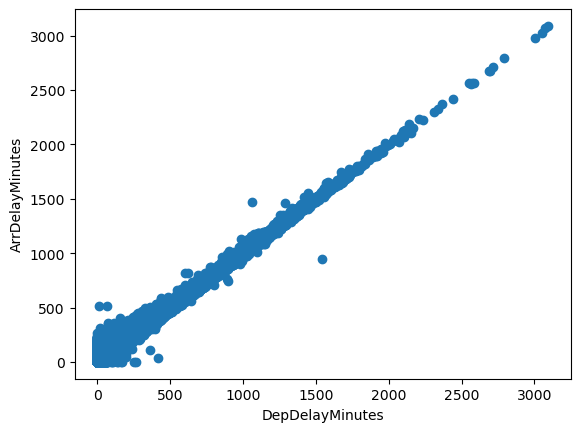

In [ ]:
# Arrival delay is strongly linearly correlated with departure delay.
# Consider using Arrival Delay only. We probably care more about arrival delay than departure delay (if key stakeholders are passengers).
plt.scatter(df_relevant_nonull.DepDelayMinutes, df_relevant_nonull.ArrDelayMinutes)
plt.xlabel('DepDelayMinutes')
plt.ylabel('ArrDelayMinutes')
plt.show()

In [ ]:
DepartureDelayGroups_table = df_relevant_nonull.DepartureDelayGroups.value_counts().sort_index()
DepartureDelayGroups_table

DepartureDelayGroups
-2.0       30396
-1.0     3798707
 0.0     1288663
 1.0      388704
 2.0      199691
 3.0      122998
 4.0       82504
 5.0       58181
 6.0       43344
 7.0       32759
 8.0       25203
 9.0       19763
 10.0      15840
 11.0      12683
 12.0      66434
Name: count, dtype: int64

In [ ]:
ArrivalDelayGroups_table = df_relevant_nonull.ArrivalDelayGroups.value_counts().sort_index()
ArrivalDelayGroups_table

ArrivalDelayGroups
-2.0     1583783
-1.0     2466704
 0.0     1067324
 1.0      401559
 2.0      199467
 3.0      119535
 4.0       79751
 5.0       56743
 6.0       42103
 7.0       31781
 8.0       24765
 9.0       19838
 10.0      15457
 11.0      12258
 12.0      64802
Name: count, dtype: int64

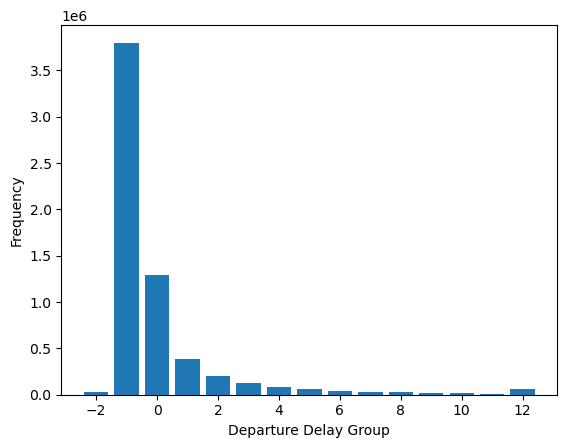

In [ ]:
plt.bar(DepartureDelayGroups_table.index, DepartureDelayGroups_table.values)
plt.xlabel('Departure Delay Group')
plt.ylabel('Frequency')
plt.show()

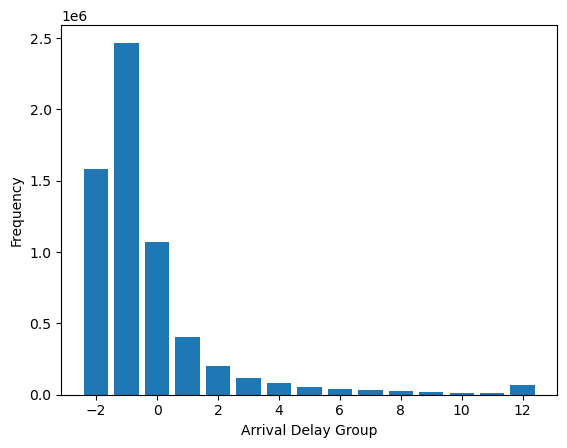

In [ ]:
plt.bar(ArrivalDelayGroups_table.index, ArrivalDelayGroups_table.values)
plt.xlabel('Arrival Delay Group')
plt.ylabel('Frequency')
plt.show()

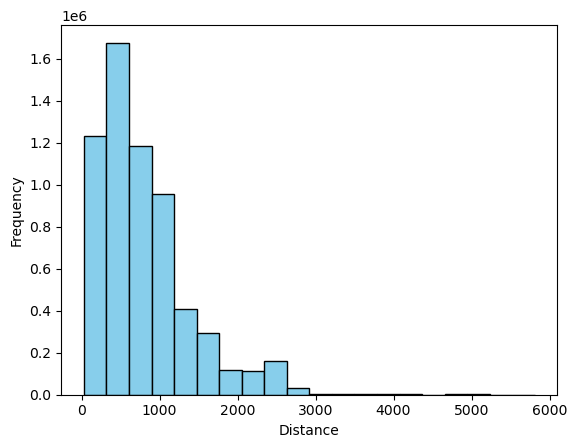

In [ ]:
# distance is right skewed
plt.hist(df_relevant_nonull.Distance, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()

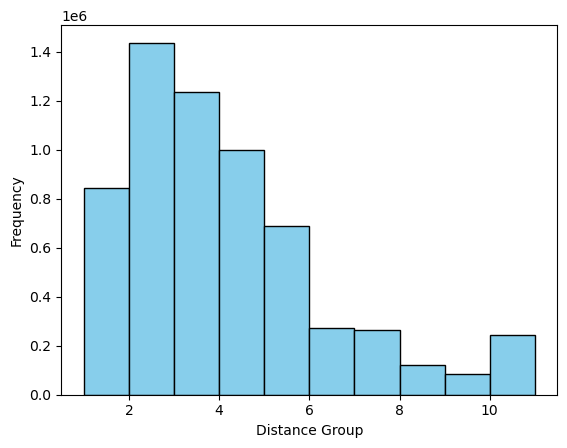

In [ ]:
# distance is right skewed
plt.hist(df_relevant_nonull.DistanceGroup, color='skyblue', edgecolor='black')
plt.xlabel('Distance Group')
plt.ylabel('Frequency')
plt.show()

In [ ]:
df_relevant_nonull_numerical = df_relevant_nonull.select_dtypes(include='number')
df_relevant_nonull_numerical.shape

(6185870, 22)

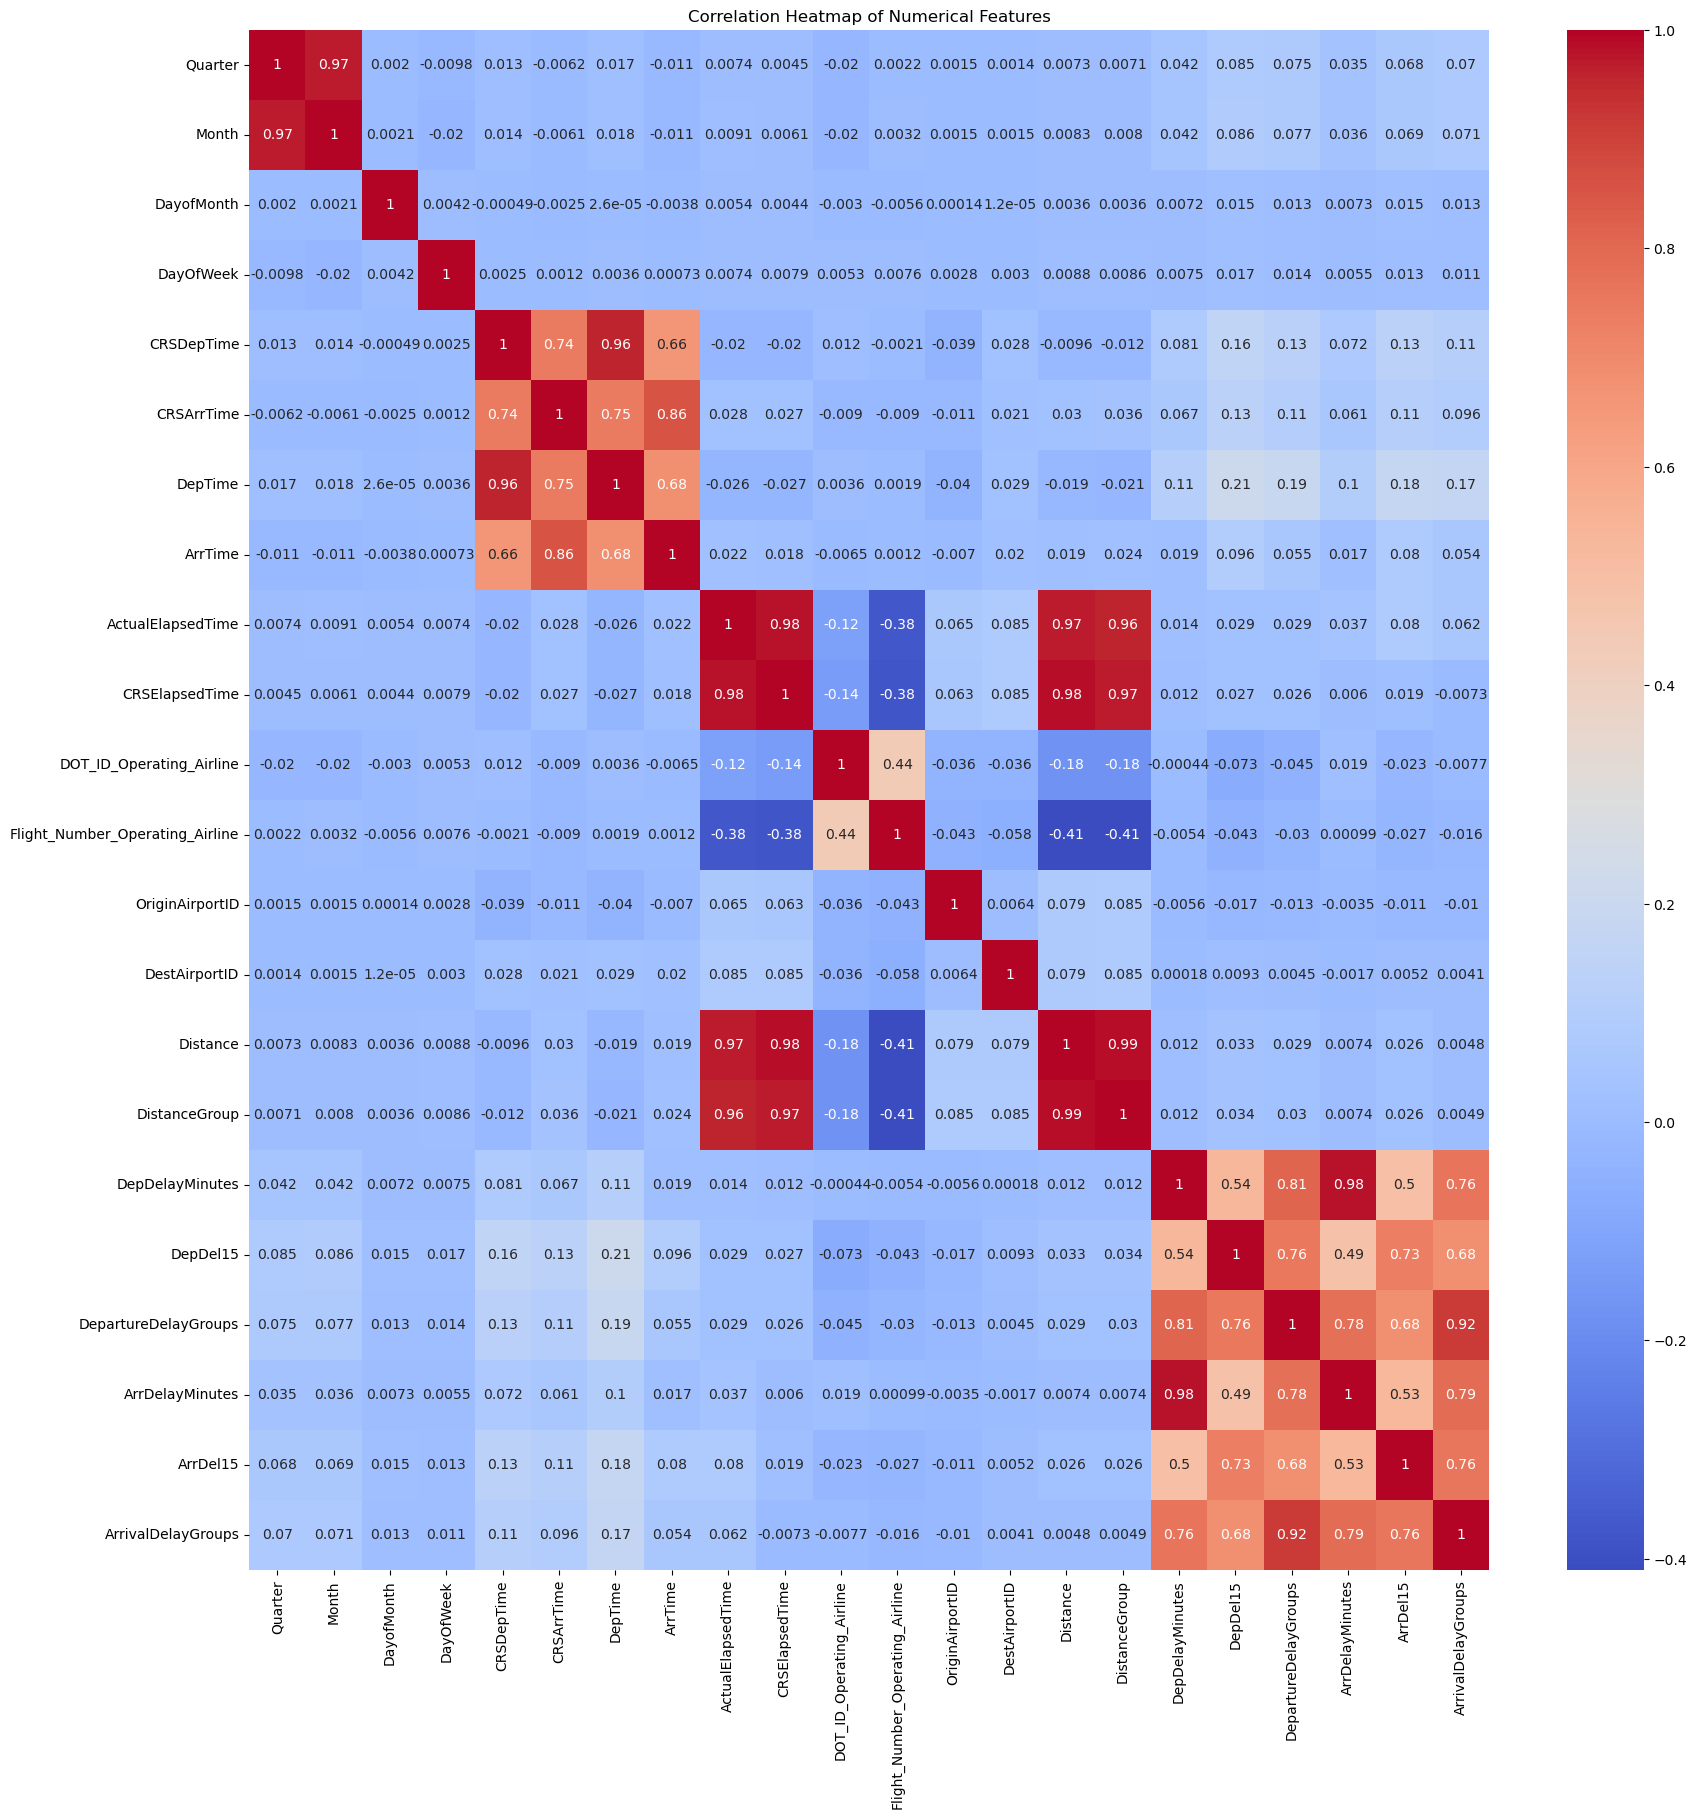

In [ ]:
# check correlation
correlation_matrix_scores = df_relevant_nonull_numerical.corr()

# Plot heatmap of correlations
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix_scores, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

When selecting the following features, select only 1 feature in each group due to correlation (or because they basically mean the same thing):  

1. Quarter & Month
2. CRSDepTime & CRSArrTime
3. DOT_ID_Operating_Airline, Operating_Airline, Airline
4. OriginAirportID, Origin, OriginCityName
5. DestAirportID, Dest, DestCityName
6. Distance & DistanceGroup


When selecting a target variable, select 1 based on your type of prediction:

1. Continuous Prediction: ArrDelayMinutes
2. Binary Prediction: ArrDel15
3. Categorical Prediction: ArrivalDelayGroups

In [ ]:
# This may take a while. (2-3 minutes)
df_relevant_nonull.to_csv('Cleaned_Combined_Flights_2021.csv')

# FEATURE ENGINEERING

### New Features

In [ ]:
# Create a new categorical variable for Weekdays vs. Weekends
def weekday_or_weekend(day):
    if day in [6, 7]:  # Saturday (6) and Sunday (7)
        return 'Weekend'
    else:
        return 'Weekday'


df_relevant_nonull = df_relevant_nonull.copy()
# Apply the function to the 'DayOfWeek' column
df_relevant_nonull['WeekdayOrWeekend'] = df_relevant_nonull['DayOfWeek'].apply(weekday_or_weekend)

In [ ]:
df_relevant_nonull['FlightDate'] = pd.to_datetime(df_relevant_nonull['FlightDate'])

# Extract useful time-based features
df_relevant_nonull['Season'] = df_relevant_nonull['Month'].apply(lambda x: 'Winter' if x in [12, 1, 2] else
                                              'Spring' if x in [3, 4, 5] else
                                              'Summer' if x in [6, 7, 8] else
                                              'Fall')  # Add season based on the month

In [ ]:
# Create a uniform time scale (minutes)
def time_to_minutes(time):
    # Extract hours and minutes, handling edge cases like NaN
    if pd.isnull(time):
        return 0
    hours = time // 100
    minutes = time % 100
    return hours * 60 + minutes

# Apply the conversion
df_relevant_nonull['CRSDepTimeMinutes'] = df_relevant_nonull['CRSDepTime'].apply(time_to_minutes)
df_relevant_nonull['DepTimeMinutes'] = df_relevant_nonull['DepTime'].apply(time_to_minutes)

# Calculate Arr_deviation
# 1. Departure Deviation
df_relevant_nonull['DepDeviation'] = df_relevant_nonull['DepTimeMinutes'] - df_relevant_nonull['CRSDepTimeMinutes']

# 2. In-Flight Duration Deviation
df_relevant_nonull['DurationDeviation'] = df_relevant_nonull['ActualElapsedTime'] - df_relevant_nonull['CRSElapsedTime']

# Combine both to calculate Arr_deviation
df_relevant_nonull['Arr_deviation'] = df_relevant_nonull['DepDeviation'] + df_relevant_nonull['DurationDeviation']

#Drop irrelevant columns
df_relevant_nonull.drop(['DepDeviation', 'DurationDeviation'], axis=1, inplace=True)

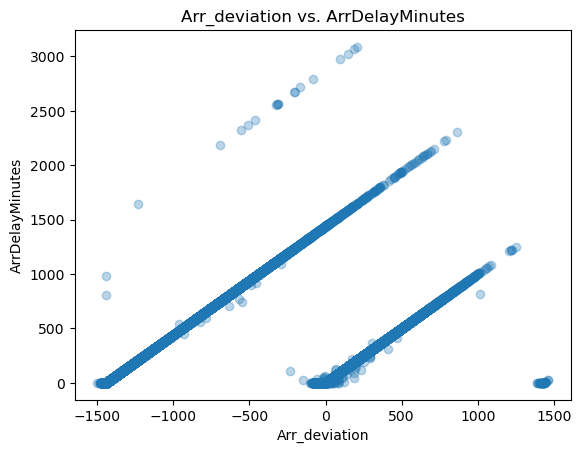

In [ ]:
#Assess correlation of new feature
# Scatter plot of Arr_deviation vs ArrDelayMinutes
plt.scatter(df_relevant_nonull['Arr_deviation'], df_relevant_nonull['ArrDelayMinutes'], alpha=0.3)
plt.xlabel('Arr_deviation')
plt.ylabel('ArrDelayMinutes')
plt.title('Arr_deviation vs. ArrDelayMinutes')
plt.show()

In [ ]:
#Low correlation, hence to provide more predictive benefits
correlation = df_relevant_nonull[['Arr_deviation', 'ArrDelayMinutes']].corr()
print(correlation)

                 Arr_deviation  ArrDelayMinutes
Arr_deviation         1.000000         0.133804
ArrDelayMinutes       0.133804         1.000000


In [ ]:
#Proxy for Tail_number

# Avg number of delay minutes per aircraft (Tail_Number)
avg_delays_per_aircraft = df_relevant_nonull.groupby('Tail_Number')['DepDelayMinutes'].mean()

# Map the average delay back to the original DataFrame
df_relevant_nonull['AvgDelaysPerAircraft'] = df_relevant_nonull['Tail_Number'].map(avg_delays_per_aircraft)

# Replace NaN with 0 for aircraft with no recorded delays
df_relevant_nonull['AvgDelaysPerAircraft'].fillna(0, inplace=True)

In [ ]:
# Total number of flights per airline
total_flights_per_airline = df_relevant_nonull['Airline'].value_counts()

# Count the number of unique flight dates
unique_flight_dates = df_relevant_nonull['FlightDate'].nunique()

# Calculate the average number of flights per day for each airline
avg_flights_per_day_per_airline = total_flights_per_airline / unique_flight_dates

# Map the average flights per day back to the original DataFrame
df_relevant_nonull['AvgFlightsPerDay'] = df_relevant_nonull['Airline'].map(avg_flights_per_day_per_airline)


In [ ]:
#Proxy feature for categorical airport features

total_flights = len(df_relevant_nonull)

# Total number of flights per Origin airport
origin_capacity = df_relevant_nonull.groupby('Origin')['FlightDate'].count().reset_index()
origin_capacity.rename(columns={'FlightDate': 'TotalFlightsFromOrigin'}, inplace=True)

# Merge Origin capacity
df_relevant_nonull = df_relevant_nonull.merge(origin_capacity, on='Origin', how='left')
df_relevant_nonull.rename(columns={'TotalFlightsFromOrigin': 'Origin_capacity'}, inplace=True)
df_relevant_nonull['Origin_capacity'] = (df_relevant_nonull['Origin_capacity']/total_flights).round(4)


# Total number of flights for each destination airport
dest_capacity = df_relevant_nonull.groupby('Dest')['FlightDate'].count().reset_index()
dest_capacity.rename(columns={'FlightDate': 'TotalFlightsToDest'}, inplace=True)

# Merge Destination capacity
df_relevant_nonull = df_relevant_nonull.merge(dest_capacity, on='Dest', how='left')
df_relevant_nonull.rename(columns={'TotalFlightsToDest': 'Dest_capacity'}, inplace=True)
df_relevant_nonull['Dest_capacity'] = (df_relevant_nonull['Dest_capacity']/total_flights).round(4)

### One-Hot Encoding

In [ ]:
df_relevant_nonull = pd.get_dummies(df_relevant_nonull, columns=['WeekdayOrWeekend'], prefix='Is')

#Keep only is_Weekend due to perfect correlation?
#df_relevant_nonull = df_relevant_nonull.drop(columns=['Is_Weekday'])

In [ ]:
# One-hot encode the 'Season' column
df_relevant_nonull = pd.get_dummies(df_relevant_nonull, columns=['Season'], prefix='Is')

In [ ]:
categorical_columns = df_relevant_nonull.select_dtypes(include=['object'])
print(categorical_columns.head())

  Operating_Airline                Airline Tail_Number Origin  \
0                OO  SkyWest Airlines Inc.      N728SK    SGU   
1                OO  SkyWest Airlines Inc.      N752SK    PHX   
2                OO  SkyWest Airlines Inc.      N766SK    MHT   
3                OO  SkyWest Airlines Inc.      N752EV    DFW   
4                OO  SkyWest Airlines Inc.      N715SK    PHX   

          OriginCityName OriginStateName Dest  \
0         St. George, UT            Utah  PHX   
1            Phoenix, AZ         Arizona  SGU   
2         Manchester, NH   New Hampshire  ORD   
3  Dallas/Fort Worth, TX           Texas  TRI   
4            Phoenix, AZ         Arizona  BFL   

                         DestCityName DestStateName  
0                         Phoenix, AZ       Arizona  
1                      St. George, UT          Utah  
2                         Chicago, IL      Illinois  
3  Bristol/Johnson City/Kingsport, TN     Tennessee  
4                     Bakersfield, CA    Cal

In [ ]:
#View unique values
# df_relevant_nonull['Operating_Airline'].value_counts()

In [ ]:
# One-hot encode the 'Operating Arline' column
df_relevant_nonull = pd.get_dummies(df_relevant_nonull, columns=['Airline'])

In [ ]:
df_relevant_nonull.tail()

,Quarter,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,DepTime,ArrTime,ActualElapsedTime,CRSElapsedTime,...,"Airline_GoJet Airlines, LLC d/b/a United Express",Airline_Hawaiian Airlines Inc.,Airline_Horizon Air,Airline_JetBlue Airways,Airline_Mesa Airlines Inc.,Airline_Republic Airlines,Airline_SkyWest Airlines Inc.,Airline_Southwest Airlines Co.,Airline_Spirit Air Lines,Airline_United Air Lines Inc.
6185865,2,6,1,2,1255,1430,1301.0,1421.0,80.0,95.0,...,False,False,False,False,False,False,False,True,False,False
6185866,2,6,1,2,730,900,727.0,845.0,78.0,90.0,...,False,False,False,False,False,False,False,True,False,False
6185867,2,6,1,2,800,1110,757.0,1101.0,124.0,130.0,...,False,False,False,False,False,False,False,True,False,False
6185868,2,6,1,2,1300,1620,1252.0,1559.0,127.0,140.0,...,False,False,False,False,False,False,False,True,False,False
6185869,2,6,1,2,1925,2055,1948.0,2116.0,88.0,90.0,...,False,False,False,False,False,False,False,True,False,False


In [ ]:
#Find a proxy for arrival and destination states to encode patterns other than airport capacity.


In [ ]:
df_relevant_nonull.drop(['Tail_Number', 'OriginCityName', 'Origin', 'OriginStateName'
                        , 'Dest', 'DestCityName', 'DestStateName', 'Operating_Airline', 'FlightDate']
                        , axis=1, inplace=True)

In [ ]:
df_relevant_nonull.to_csv('Transformed_Combined_Flights_2021.csv')

# TEST TRAIN SPLIT

In [ ]:
X = df_relevant_nonull.drop(columns=['ArrDel15'])  # Features
y = df_relevant_nonull['ArrDel15']  # Target Var

#used random stratification because of class imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train = X_train.astype({col: 'int' for col in X_train.select_dtypes(include='bool').columns})
X_test = X_test.astype({col: 'int' for col in X_test.select_dtypes(include='bool').columns})

In [ ]:
# distribution in both training and testing sets
print("Training has:")
print(y_train.value_counts(normalize=True))

print("\nTesting has:")
print(y_test.value_counts(normalize=True))

Training has:
ArrDel15
0.0    0.827339
1.0    0.172661
Name: proportion, dtype: float64

Testing has:
ArrDel15
0.0    0.827339
1.0    0.172661
Name: proportion, dtype: float64


### Standardization

In [ ]:
#Change all hh:mm time columns to minutes??
# df_relevant_nonull.info()

In [ ]:
standard_scaler = StandardScaler()

numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns

# Create a copy of the original X_train and X_test for standardization
X_train_std = X_train.copy()
X_test_std = X_test.copy()

X_train_std[numerical_cols] = standard_scaler.fit_transform(X_train_std[numerical_cols])
X_test_std[numerical_cols] = standard_scaler.transform(X_test_std[numerical_cols])

# MODEL SELECTION - model 2

## LINEAR REGRESSION MODEL

In [ ]:
# Features (Exclude target-related columns to avoid leakage)
X = (df_relevant_nonull
     .drop(columns=['ArrDelayMinutes',  # Target variable
                    'ArrDel15',         # Binary target derived from delays
                    'ArrivalDelayGroups',  # Target leakage
                    'Arr_deviation',    # Deviation derived from delay
                    'DepDelayMinutes',  # Departure delay (highly correlated)
                    'DepDel15',         # Departure delay binary indicator
                    'DepartureDelayGroups'  # Departure delay grouped
                   ])
    )

# Target variable
y = df_relevant_nonull['ArrDelayMinutes']


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")


Training set size: (4948696, 50)
Testing set size: (1237174, 50)


In [ ]:
from sklearn.linear_model import LinearRegression

# Initialize the model
linear_model = LinearRegression()

# Train the model
linear_model.fit(X_train, y_train)


LinearRegression()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
# Make predictions
y_pred = linear_model.predict(X_test)

# Calculate RMSE and R²
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


Root Mean Squared Error (RMSE): 45.41
R² Score: 0.07


In [ ]:
# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': linear_model.coef_
}).sort_values(by='Coefficient', ascending=False)

print("\nFeature Importance:")
print(feature_importance)



Feature Importance:
                                              Feature  Coefficient
21                                      Dest_capacity    46.253855
26                                          Is_Summer     4.624501
36                       Airline_Empire Airlines Inc.     4.086531
37                          Airline_Endeavor Air Inc.     1.357576
18                               AvgDelaysPerAircraft     0.880644
34  Airline_Commutair Aka Champlain Enterprises, Inc.     0.831549
0                                             Quarter     0.780863
23                                         Is_Weekend     0.603964
8                                   ActualElapsedTime     0.583473
46                      Airline_SkyWest Airlines Inc.     0.583442
28                Airline_Air Wisconsin Airlines Corp     0.543533
44                         Airline_Mesa Airlines Inc.     0.501976
15                                      DistanceGroup     0.389990
47                     Airline_Southwest 

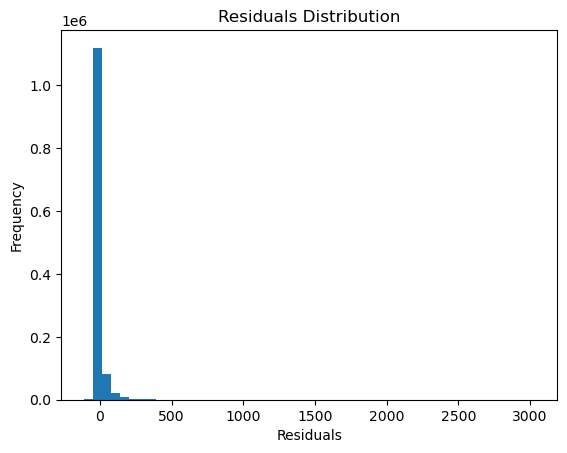

In [ ]:
import matplotlib.pyplot as plt

# Residuals
residuals = y_test - y_pred

plt.hist(residuals, bins=50)
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()


In [ ]:
#add comment to tell team why i added the lines below
# Improving the Model
# I added the steps below because the mdoel did not perfom well at first
# 1. **Outlier Capping:** Extreme delays were influencing the model disproportionately, leading to high RMSE.
#    By capping outliers, we aim to reduce the variance caused by rare, extreme cases.
# 2. **Interaction Features:** Since Linear regression doesn't handle feature interactions. Adding an
#    interaction between `Distance` and `AvgDelaysPerAircraft` helps the model capture more complex relationships.

In [ ]:
# Add interaction feature to capture relationships between Distance and AvgDelaysPerAircraft.
# This is added because linear regression cannot inherently handle interactions, and this relationship
# could improve the model's ability to predict delays for longer or shorter flights.
X['Distance_AvgDelays'] = X['Distance'] * X['AvgDelaysPerAircraft']

In [ ]:
# Initialize scaler
scaler = StandardScaler()

# Scale the features
X_scaled = scaler.fit_transform(X)

In [ ]:
# Cap Outliers in Target Variable to reduce the influence of extreme delays.
# Outliers (e.g., extremely long delays) can disproportionately impact the model's performance,
# leading to high error rates. By capping delays at the 95th percentile, we focus the model on the majority of delays.
upper_threshold = np.percentile(df_relevant_nonull['ArrDelayMinutes'], 95)
df_relevant_nonull['ArrDelayMinutes'] = np.clip(df_relevant_nonull['ArrDelayMinutes'], None, upper_threshold)

#Define Features and Target: Exclude delay-related features from X to avoid leakage.
# Ensures the model does not "cheat" by learning directly from features derived from delays.
X = (df_relevant_nonull
     .drop(columns=['ArrDelayMinutes', 'ArrDel15', 'ArrivalDelayGroups',
                    'Arr_deviation', 'DepDelayMinutes', 'DepDel15', 'DepartureDelayGroups'])
    )
y = df_relevant_nonull['ArrDelayMinutes']

In [ ]:
# Add interaction feature again after defining the target
# Re-adding Distance_AvgDelays so the feature is included in the training set.
X['Distance_AvgDelays'] = X['Distance'] * X['AvgDelaysPerAircraft']

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Linear Regression Model
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)


LinearRegression()

In [ ]:
# Make Predictions
y_pred = linear_model.predict(X_test_scaled)

# Evaluate the Model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


Root Mean Squared Error (RMSE): 15.60
R² Score: 0.21


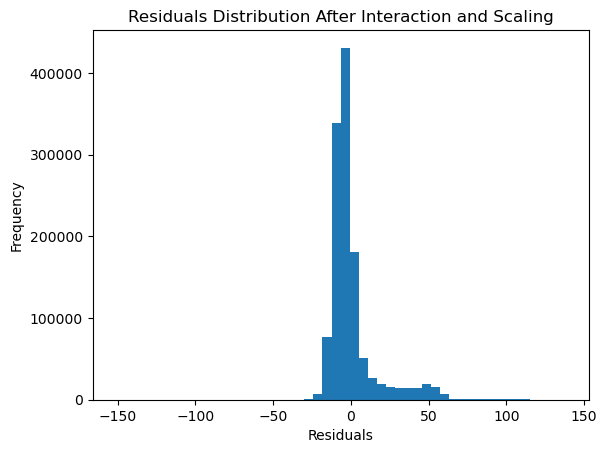

In [ ]:
# Analyze Residuals
residuals = y_test - y_pred
plt.hist(residuals, bins=50)
plt.title("Residuals Distribution After Interaction and Scaling")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()


In [ ]:
# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': linear_model.coef_
}).sort_values(by='Coefficient', ascending=False)

print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
                                              Feature   Coefficient
19                                   AvgFlightsPerDay  1.444992e+11
37                          Airline_Endeavor Air Inc.  5.318048e+10
38                                  Airline_Envoy Air  5.287600e+10
29                       Airline_Alaska Airlines Inc.  5.233808e+10
45                          Airline_Republic Airlines  5.219754e+10
33                                Airline_Comair Inc.  5.219156e+10
43                            Airline_JetBlue Airways  5.130170e+10
48                           Airline_Spirit Air Lines  5.060844e+10
49                      Airline_United Air Lines Inc.  4.967733e+10
44                         Airline_Mesa Airlines Inc.  4.858348e+10
39                     Airline_Frontier Airlines Inc.  4.653927e+10
42                                Airline_Horizon Air  4.560713e+10
30                              Airline_Allegiant Air  4.398807e+10
32                Airline_C

## Regression Model Hyperparameter Tuning and Evaluation

In [ ]:
X.head()

,Quarter,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,DepTime,ArrTime,ActualElapsedTime,CRSElapsedTime,...,Airline_Hawaiian Airlines Inc.,Airline_Horizon Air,Airline_JetBlue Airways,Airline_Mesa Airlines Inc.,Airline_Republic Airlines,Airline_SkyWest Airlines Inc.,Airline_Southwest Airlines Co.,Airline_Spirit Air Lines,Airline_United Air Lines Inc.,Distance_AvgDelays
0,1,3,3,3,724,843,714.0,818.0,64.0,79.0,...,False,False,False,False,False,True,False,False,False,5445.274696
1,1,3,3,3,922,1040,917.0,1031.0,74.0,78.0,...,False,False,False,False,False,True,False,False,False,4001.760103
2,1,3,3,3,1330,1530,1321.0,1501.0,160.0,180.0,...,False,False,False,False,False,True,False,False,False,15992.070817
3,1,3,3,3,1645,2010,1636.0,2002.0,146.0,145.0,...,False,False,False,False,False,True,False,False,False,16558.871091
4,1,3,3,3,1844,1925,1838.0,1903.0,85.0,101.0,...,False,False,False,False,False,True,False,False,False,7206.876333


In [ ]:
print(df_relevant_nonull.columns)

Index(['Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'CRSDepTime',
       'CRSArrTime', 'DepTime', 'ArrTime', 'ActualElapsedTime',
       'CRSElapsedTime', 'DOT_ID_Operating_Airline',
       'Flight_Number_Operating_Airline', 'OriginAirportID', 'DestAirportID',
       'Distance', 'DistanceGroup', 'DepDelayMinutes', 'DepDel15',
       'DepartureDelayGroups', 'ArrDelayMinutes', 'ArrDel15',
       'ArrivalDelayGroups', 'CRSDepTimeMinutes', 'DepTimeMinutes',
       'Arr_deviation', 'AvgDelaysPerAircraft', 'AvgFlightsPerDay',
       'Origin_capacity', 'Dest_capacity', 'Is_Weekday', 'Is_Weekend',
       'Is_Fall', 'Is_Spring', 'Is_Summer', 'Is_Winter',
       'Airline_Air Wisconsin Airlines Corp', 'Airline_Alaska Airlines Inc.',
       'Airline_Allegiant Air', 'Airline_American Airlines Inc.',
       'Airline_Capital Cargo International', 'Airline_Comair Inc.',
       'Airline_Commutair Aka Champlain Enterprises, Inc.',
       'Airline_Delta Air Lines Inc.', 'Airline_Empire Airlines Inc.',


In [ ]:
# removing features that are highly correlated with others to avoid multicolinearity
# removing other features that may afffect the results
# also removing features that would not normally be known before flight is delayed


# played around with the features here but no significant improvement


X_clean = (X
     .drop(columns=['Quarter',  # Higly correlated with month
                    'DistanceGroup',  # Higly correlated with distance
                    'ActualElapsedTime', # Higly correlated with CRSElapsedTime
                    'CRSDepTime',  # will keep crsdeptimeminutes
                    'DepTimeMinutes',
                    'ArrTime',   # will not normally be known
                    'DepTime',   # will not normally be known
                    'CRSArrTime'  # highly correlated with CRSDepTime
                   ]))

In [ ]:
X_clean.columns

Index(['Month', 'DayofMonth', 'DayOfWeek', 'CRSElapsedTime',
       'DOT_ID_Operating_Airline', 'Flight_Number_Operating_Airline',
       'OriginAirportID', 'DestAirportID', 'Distance', 'CRSDepTimeMinutes',
       'AvgDelaysPerAircraft', 'AvgFlightsPerDay', 'Origin_capacity',
       'Dest_capacity', 'Is_Weekday', 'Is_Weekend', 'Is_Fall', 'Is_Spring',
       'Is_Summer', 'Is_Winter', 'Airline_Air Wisconsin Airlines Corp',
       'Airline_Alaska Airlines Inc.', 'Airline_Allegiant Air',
       'Airline_American Airlines Inc.', 'Airline_Capital Cargo International',
       'Airline_Comair Inc.',
       'Airline_Commutair Aka Champlain Enterprises, Inc.',
       'Airline_Delta Air Lines Inc.', 'Airline_Empire Airlines Inc.',
       'Airline_Endeavor Air Inc.', 'Airline_Envoy Air',
       'Airline_Frontier Airlines Inc.',
       'Airline_GoJet Airlines, LLC d/b/a United Express',
       'Airline_Hawaiian Airlines Inc.', 'Airline_Horizon Air',
       'Airline_JetBlue Airways', 'Airline_Mesa A

In [ ]:
# train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.2, random_state=42)

In [ ]:
X_train.columns

Index(['Month', 'DayofMonth', 'DayOfWeek', 'CRSElapsedTime',
       'DOT_ID_Operating_Airline', 'Flight_Number_Operating_Airline',
       'OriginAirportID', 'DestAirportID', 'Distance', 'CRSDepTimeMinutes',
       'AvgDelaysPerAircraft', 'AvgFlightsPerDay', 'Origin_capacity',
       'Dest_capacity', 'Is_Weekday', 'Is_Weekend', 'Is_Fall', 'Is_Spring',
       'Is_Summer', 'Is_Winter', 'Airline_Air Wisconsin Airlines Corp',
       'Airline_Alaska Airlines Inc.', 'Airline_Allegiant Air',
       'Airline_American Airlines Inc.', 'Airline_Capital Cargo International',
       'Airline_Comair Inc.',
       'Airline_Commutair Aka Champlain Enterprises, Inc.',
       'Airline_Delta Air Lines Inc.', 'Airline_Empire Airlines Inc.',
       'Airline_Endeavor Air Inc.', 'Airline_Envoy Air',
       'Airline_Frontier Airlines Inc.',
       'Airline_GoJet Airlines, LLC d/b/a United Express',
       'Airline_Hawaiian Airlines Inc.', 'Airline_Horizon Air',
       'Airline_JetBlue Airways', 'Airline_Mesa A

In [ ]:
# scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train Linear Regression Model
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

LinearRegression()

In [ ]:
# Make Predictions
y_pred = linear_model.predict(X_test_scaled)

# Evaluate the Model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

RMSE: 17.03, MAE: 11.27, R²: 0.06


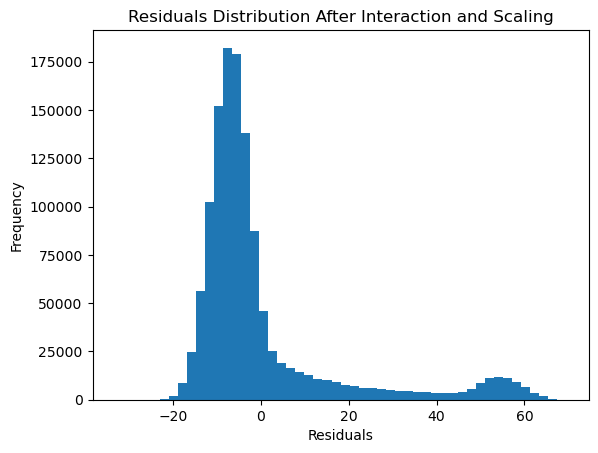

In [ ]:
# Analyze Residuals
residuals = y_test - y_pred
plt.hist(residuals, bins=50)
plt.title("Residuals Distribution After Interaction and Scaling")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()



Feature Importance:
                                              Feature   Coefficient
4                            DOT_ID_Operating_Airline  1.284195e+11
15                                         Is_Weekend  9.807654e+10
14                                         Is_Weekday  9.807654e+10
39                     Airline_Southwest Airlines Co.  2.013126e+10
18                                          Is_Summer  5.492990e+09
16                                            Is_Fall  5.452091e+09
17                                          Is_Spring  5.158406e+09
19                                          Is_Winter  4.918180e+09
9                                   CRSDepTimeMinutes  2.307586e+00
10                               AvgDelaysPerAircraft  1.998581e+00
8                                            Distance  1.927898e+00
0                                               Month  1.264635e+00
13                                      Dest_capacity  4.099728e-01
1                          

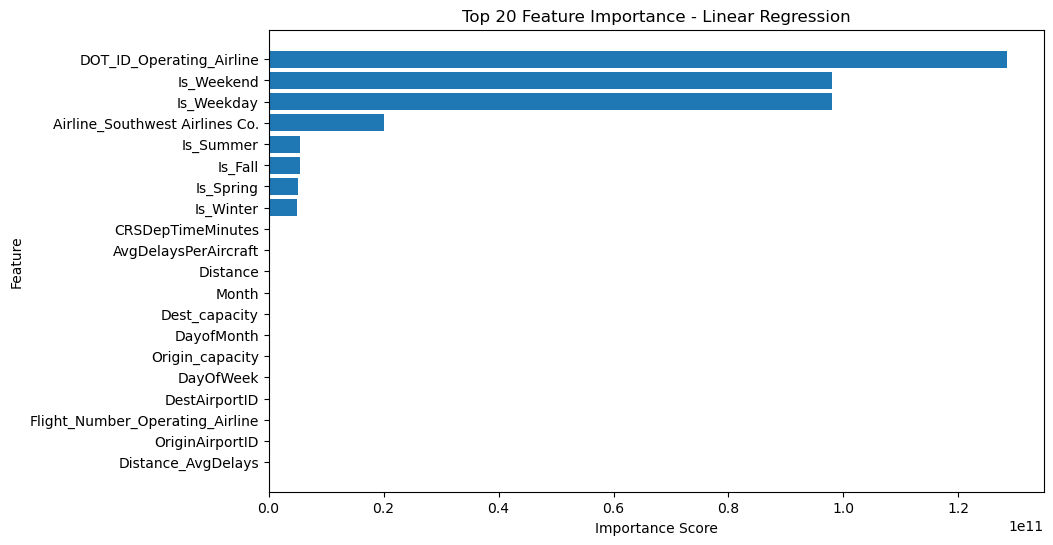

In [ ]:
# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X_clean.columns,
    'Coefficient': linear_model.coef_
}).sort_values(by='Coefficient', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot top 20 important features
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'][:20], feature_importance['Coefficient'][:20])
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 20 Feature Importance - Linear Regression")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# dataset is large so computation is expensive, data is sampled in order to manage resources
# tried running with the whole dataset first, it took too long and the results were not that different in the end

X_train_sample = X_train.sample(frac=0.5, random_state=42)  # sample 50% of the data
y_train_sample = y_train.loc[X_train_sample.index]

#X_test_sample = X_test.sample(frac=0.2, random_state=42)  # sample 20% of the data
#y_test_sample = y_test.loc[X_test_sample.index]

In [ ]:
# scale Features and test sampled dataset
scaler = StandardScaler()
X_train_scaled_sm = scaler.fit_transform(X_train_sample)
X_test_scaled_sm = scaler.transform(X_test)

# train Linear Regression Model
linear_model = LinearRegression()
linear_model.fit(X_train_scaled_sm, y_train_sample)

# Make Predictions
y_pred = linear_model.predict(X_test_scaled_sm)

# Evaluate the Model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")



RMSE: 17.03, MAE: 11.27, R²: 0.06



Feature Importance:
                                              Feature   Coefficient
11                                   AvgFlightsPerDay  1.111367e+12
15                                         Is_Weekend  2.130175e+11
14                                         Is_Weekday  2.130175e+11
22                              Airline_Allegiant Air  9.746784e+10
24                Airline_Capital Cargo International  9.707028e+10
31                     Airline_Frontier Airlines Inc.  9.559986e+10
26  Airline_Commutair Aka Champlain Enterprises, Inc.  9.370165e+10
20                Airline_Air Wisconsin Airlines Corp  9.233236e+10
34                                Airline_Horizon Air  9.214641e+10
36                         Airline_Mesa Airlines Inc.  9.132631e+10
32   Airline_GoJet Airlines, LLC d/b/a United Express  8.862362e+10
33                     Airline_Hawaiian Airlines Inc.  8.523142e+10
40                           Airline_Spirit Air Lines  8.209903e+10
21                       Ai

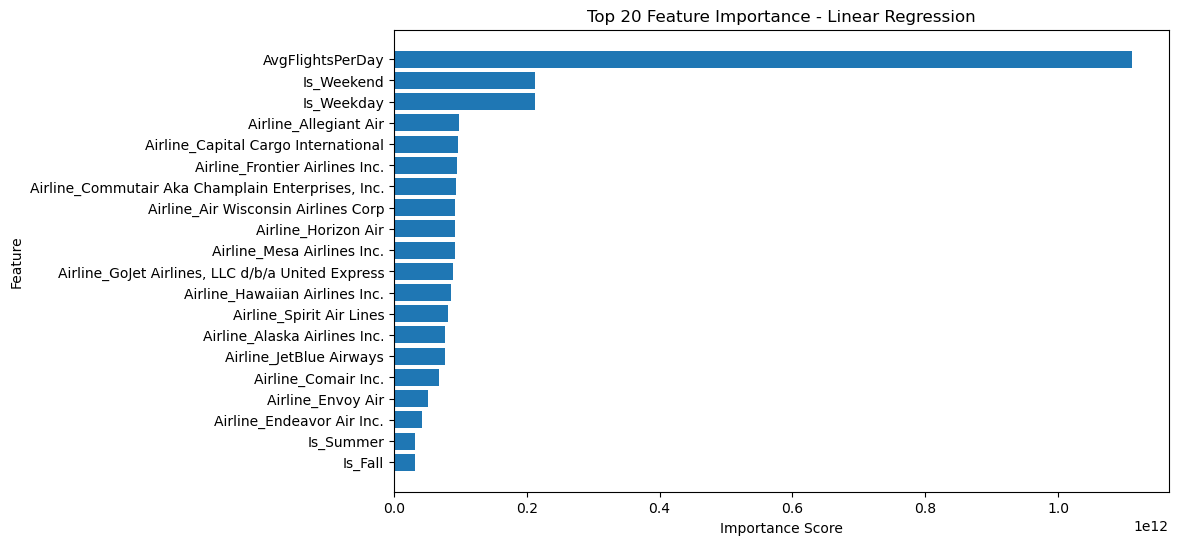

In [ ]:
# Feature Importance

feature_importance = pd.DataFrame({
    'Feature': X_clean.columns,
    'Coefficient': linear_model.coef_
}).sort_values(by='Coefficient', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot top 20 important features
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'][:20], feature_importance['Coefficient'][:20])
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 20 Feature Importance - Linear Regression")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# grid search function

# to store results
results = []

# function to evaluate models
def evaluate_model(name, model, X_train, y_train, X_test, y_test, param_grid):

    # run grid search with 5 fold cross validation
    grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(X_train, y_train)

    # get the best model
    best_model = grid_search.best_estimator_

    # fit best model to test data
    y_pred = best_model.predict(X_test)

    # evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # store results
    results.append({'Model': name, 'RMSE' : rmse, 'MAE' : mae, 'R_squared' : r2})


In [ ]:
# randomised search function - because grid search was computationally expensive and taking a lot of time to run

# to store results
results2 = []

# function to evaluate models
def evaluate_model2(name, model, X_train, y_train, X_test, y_test, param_dist):

    # run rnadomised search with 5 fold cross validation
    random_search = RandomizedSearchCV(model, param_dist, scoring='neg_mean_squared_error', cv=5, n_iter=20, random_state=42)
    random_search.fit(X_train, y_train)

    # get the best model
    best_model = random_search.best_estimator_

    # fit best model to test data
    y_pred = best_model.predict(X_test)

    # evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # store results
    results2.append({'Model': name, 'RMSE' : rmse, 'MAE' : mae, 'R_squared' : r2})

    return best_model

In [ ]:
# evaluate Ridge regression model
ridge = Ridge()

#param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}
param_dist = {'alpha': uniform(0.01, 100)}

linear_model = evaluate_model2('Ridge Regression', ridge, X_train_scaled_sm, y_train_sample, X_test_scaled_sm, y_test, param_dist)


Feature Importance:
                                              Feature  Coefficient
9                                   CRSDepTimeMinutes     2.302608
10                               AvgDelaysPerAircraft     2.017285
8                                            Distance     1.995406
18                                          Is_Summer     1.487517
0                                               Month     1.251257
39                     Airline_Southwest Airlines Co.     0.440683
13                                      Dest_capacity     0.415096
22                              Airline_Allegiant Air     0.393955
1                                          DayofMonth     0.254105
35                            Airline_JetBlue Airways     0.252550
12                                    Origin_capacity     0.240307
2                                           DayOfWeek     0.126089
21                       Airline_Alaska Airlines Inc.     0.116129
31                     Airline_Frontier A

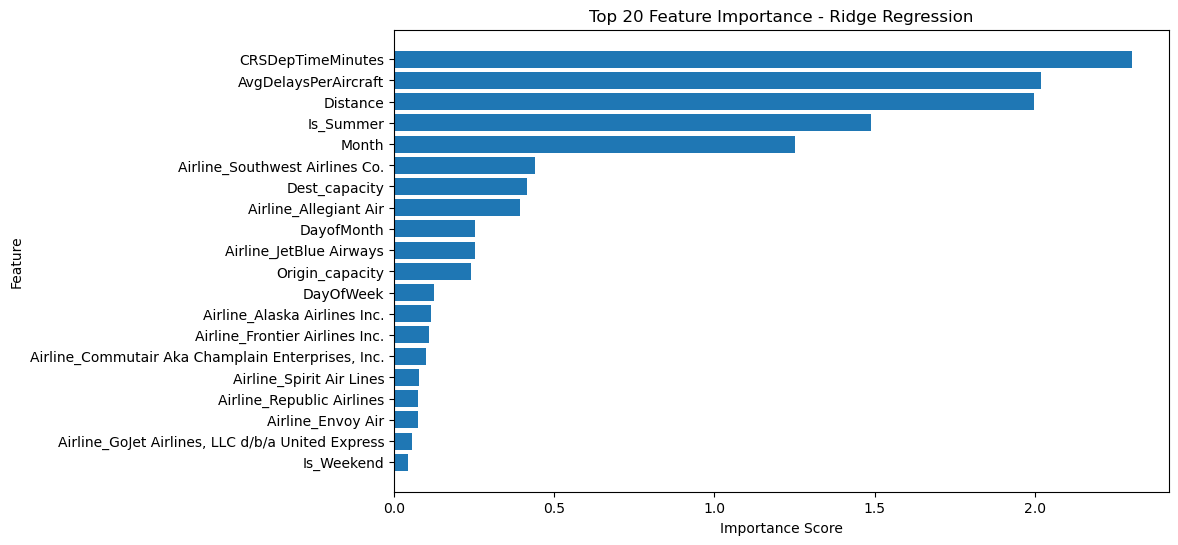

In [ ]:
# Feature Importance

feature_importance = pd.DataFrame({
    'Feature': X_clean.columns,
    'Coefficient': linear_model.coef_
}).sort_values(by='Coefficient', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot top 20 important features
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'][:20], feature_importance['Coefficient'][:20])
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 20 Feature Importance - Ridge Regression")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# evaluate Lasso regression model

#param_grid = {'alpha': [0.1, 1, 10, 100]}
lasso = Lasso()

param_dist = {'alpha': uniform(0.01, 10)}

linear_model = evaluate_model2('Lasso Regression', lasso, X_train_scaled_sm, y_train_sample, X_test_scaled_sm, y_test, param_dist)


Feature Importance:
                                              Feature  Coefficient
9                                   CRSDepTimeMinutes     2.089286
18                                          Is_Summer     1.906449
10                               AvgDelaysPerAircraft     1.872424
0                                               Month     0.810187
19                                          Is_Winter     0.270606
39                     Airline_Southwest Airlines Co.     0.194467
22                              Airline_Allegiant Air     0.162596
1                                          DayofMonth     0.042121
35                            Airline_JetBlue Airways     0.033405
34                                Airline_Horizon Air     0.000000
36                         Airline_Mesa Airlines Inc.     0.000000
37                          Airline_Republic Airlines     0.000000
23                     Airline_American Airlines Inc.    -0.000000
32   Airline_GoJet Airlines, LLC d/b/a Un

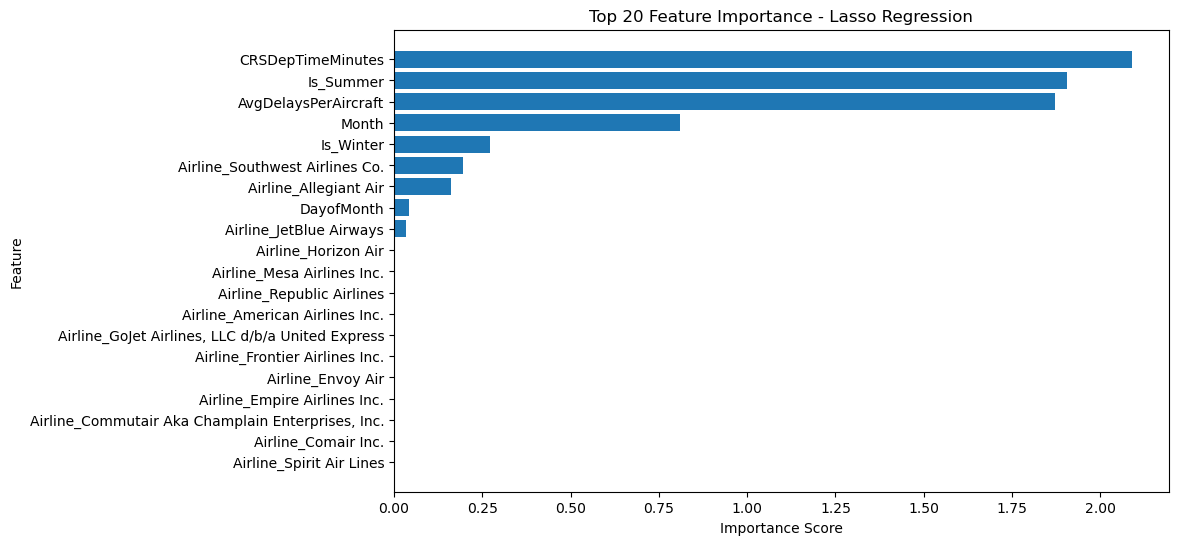

In [ ]:
# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X_clean.columns,
    'Coefficient': linear_model.coef_
}).sort_values(by='Coefficient', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot top 20 important features
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'][:20], feature_importance['Coefficient'][:20])
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 20 Feature Importance - Lasso Regression")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# get the top 20 features based on importance from lasso regression above
top_20_features = feature_importance['Feature'][:20].tolist()

X_train_top20 = X_train_sample[top_20_features]
X_test_top20 = X_test[top_20_features]



In [ ]:
# evaluate Polynomial Ridge regression model using top 20 features


# precompute polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_top20)
X_test_poly = poly.transform(X_test_top20)

In [ ]:
# standardise polynomial features
standard_scaler = StandardScaler()
X_train_poly_std = standard_scaler.fit_transform(X_train_poly)
X_test_poly_std = standard_scaler.transform(X_test_poly)



In [ ]:

# use precomputed features in Ridge regression
param_dist = {'alpha': uniform(0.01, 100)}

linear_model = evaluate_model2('Polynomial Ridge', ridge, X_train_poly_std, y_train_sample, X_test_poly_std, y_test, param_dist)


Feature Importance:
                                              Feature  Coefficient
25   CRSDepTimeMinutes Airline_Southwest Airlines Co.     3.651728
21                        CRSDepTimeMinutes Is_Summer     3.485579
3                                               Month     2.819709
41                     Is_Summer AvgDelaysPerAircraft     1.774850
23                            CRSDepTimeMinutes Month     1.766177
..                                                ...          ...
42                                    Is_Summer Month    -1.825159
110                  Airline_Southwest Airlines Co.^2    -2.085418
5                      Airline_Southwest Airlines Co.    -2.085418
20                                CRSDepTimeMinutes^2    -2.103047
77                                            Month^2    -3.991143

[230 rows x 2 columns]


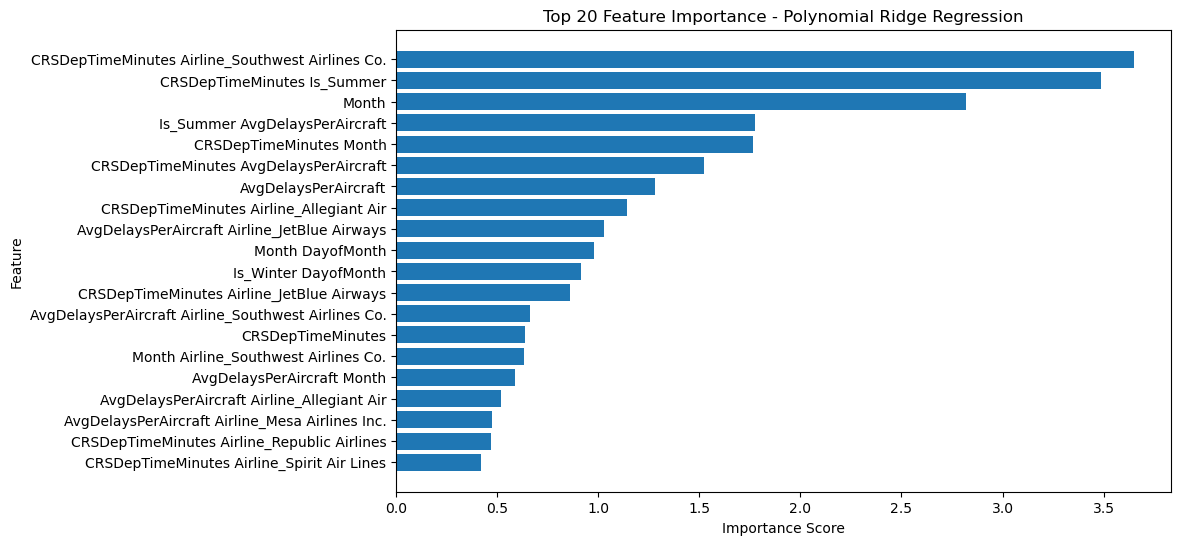

In [ ]:
# Feature Importance
poly_feature_names = poly.get_feature_names_out(top_20_features)
feature_importance = pd.DataFrame({
    'Feature': poly_feature_names,
    'Coefficient': linear_model.coef_
}).sort_values(by='Coefficient', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot top 20 important features
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'][:20], feature_importance['Coefficient'][:20])
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 20 Feature Importance - Polynomial Ridge Regression")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# convert results to dataframe
results2_df = pd.DataFrame(results2)

# sort by RMSE
results2_df = results2_df.sort_values(by='RMSE')

print(results2_df)

              Model       RMSE        MAE  R_squared
2  Polynomial Ridge  16.873112  11.100515   0.073869
0  Ridge Regression  17.025997  11.274174   0.057009
1  Lasso Regression  17.056088  11.346312   0.053673
